# Imports

In [1]:
PROJECT_DIR = "/Users/pluz999/Documents/Oxford/Thesis/queue-value"

import sys
sys.path.append(PROJECT_DIR)

import matplotlib
import os

from datetime import datetime
from tqdm import tqdm
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from definitions import ROOT_DIR
from micro_price.ImbalanceMicroPrice import ImbalanceMicroPrice
from orderbook_aggregator.ImbalanceAggregator import ImbalanceAggregator

# Set font

In [2]:
matplotlib.rc('font', family='Times New Roman') 
matplotlib.rc('text', usetex='false') 
matplotlib.rcParams.update({'font.size': 12})

# Global variables

In [3]:
csco_ticker = "CSCO"
csco_levels = 5
csco_start_date = datetime(2019,1,1)
csco_end_date = datetime(2019,1,31)

bac_ticker = "BAC"
bac_levels = 10
bac_start_date = datetime(2019,11,1)
bac_end_date = datetime(2019,11,29)

# Load and process order book data

In [4]:
csco_orderbooks: List[ImbalanceAggregator] = []
for d in tqdm(pd.date_range(csco_start_date, csco_end_date)):
    try:
        csco_orderbooks.append(ImbalanceAggregator(d, csco_ticker, csco_levels, spread_size=100))
    except FileNotFoundError:
        continue
        
csco_microprice = ImbalanceMicroPrice(csco_orderbooks)

100%|██████████| 31/31 [29:37<00:00, 57.34s/it]


In [5]:
bac_orderbooks: List[ImbalanceAggregator] = []
for d in tqdm(pd.date_range(bac_start_date, bac_end_date)):
    try:
        bac_orderbooks.append(ImbalanceAggregator(d, bac_ticker, bac_levels, spread_size=100))
    except FileNotFoundError:
        continue
        
bac_microprice = ImbalanceMicroPrice(bac_orderbooks)

100%|██████████| 29/29 [17:34<00:00, 36.35s/it]


# Calculate micro-price

In [6]:
csco_microprice_df = csco_microprice.calculate_micro_price()

In [7]:
csco_microprice_df.to_csv(os.path.join(ROOT_DIR, "models", "csco_imbalance_micro_price.csv"))

In [8]:
bac_microprice_df = bac_microprice.calculate_micro_price()

In [9]:
bac_microprice_df.to_csv(os.path.join(ROOT_DIR, "models", "bac_imbalance_micro_price.csv"))

# Plot micro-price

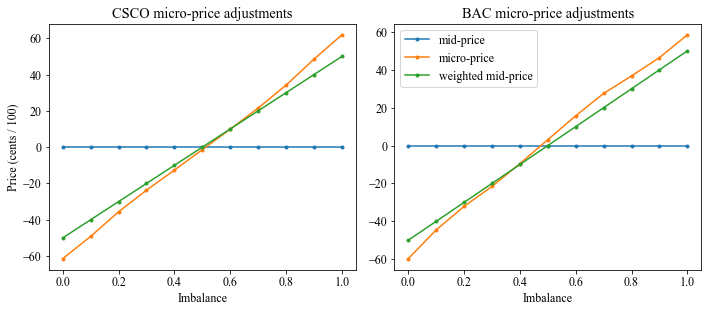

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4.5))

ax[0].plot(csco_microprice_df.index, np.repeat(0,len(csco_microprice_df.index)), ".-")
ax[0].plot(csco_microprice_df, ".-")
ax[0].plot(csco_microprice_df.index, np.linspace(-50,50,len(csco_microprice_df.index)), ".-")
ax[0].set_xlabel("Imbalance")
ax[0].set_ylabel("Price (cents / 100)")
ax[0].set_title("CSCO micro-price adjustments")

ax[1].plot(bac_microprice_df.index, np.repeat(0,len(bac_microprice_df.index)), ".-")
ax[1].plot(bac_microprice_df, ".-")
ax[1].plot(bac_microprice_df.index, np.linspace(-50,50,len(bac_microprice_df.index)), ".-")
ax[1].set_xlabel("Imbalance")
ax[1].set_title("BAC micro-price adjustments")
ax[1].legend(["mid-price"] + ["micro-price"] + ["weighted mid-price"], loc="upper left")

fig.tight_layout()

plt.show()

# Example price evolution

In [11]:
example_plot = csco_orderbooks[0].orderbook.iloc[12000:15000].copy()
example_micro_prices = [csco_microprice_df.loc[imbalance] for imbalance in example_plot["imbalance"]]
example_plot["micro_price"] = example_micro_prices

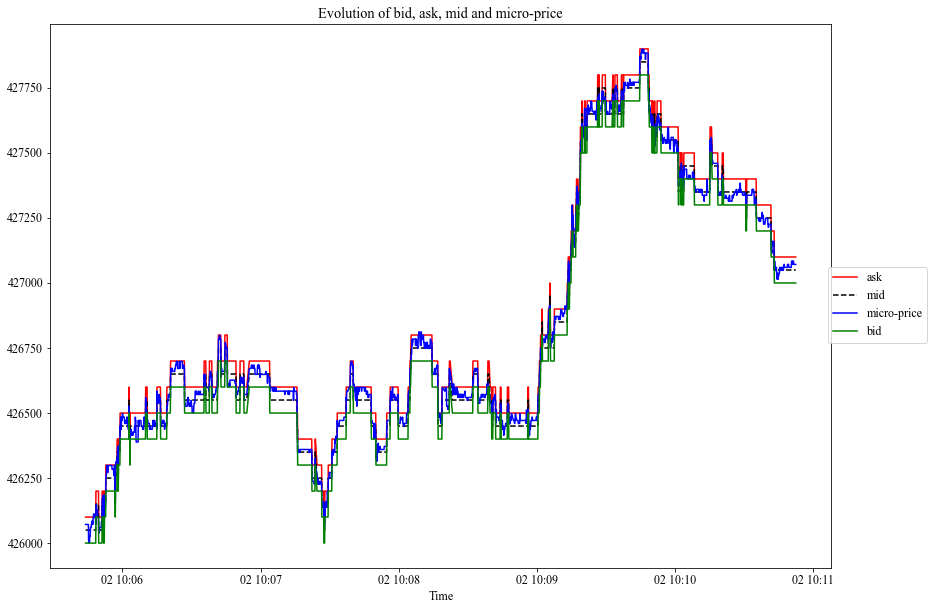

In [12]:
fig, ax = plt.subplots(figsize=(14,10))
ax.plot(example_plot["ask_price_0"], "r")
ax.plot(example_plot["mid_price"], "k--")
ax.plot(example_plot["mid_price"] + example_plot["micro_price"], "b")
ax.plot(example_plot["bid_price_0"], "g")
ax.set_title("Evolution of bid, ask, mid and micro-price")
ax.set_xlabel("Time")
fig.legend(["ask", "mid", "micro-price", "bid"], loc="right")
plt.show()